# Prueba 1
# Jorge Hoffmann
# G48

## Preliminares

A lo largo de esta prueba se resolverá un problema clásico en el análisis de texto: Extraer la polaridad de sentimiento asociado a un texto. Es decir, es un problema de clasificación. Para esto, se utilizará una base de tweets disponible en línea. Por tanto, el vector objetivo será la polaridad de un tweet, ya sea positiva o negativa. Mientras que las variables independientes serán la frecuencia de las palabras.

Para resolver este problema, se utilizarán las librerías importadas en la celda inferior. Cabe destacar que aquí ya se importan los modelos que se utilizarán o las métricas. Sin embargo, los comentarios al respecto se incluyen en la sección respectiva. Por otra parte, es posible que en la medida que se desarrolle el notebook, se deban agregar archivos de funciones auxiliares.

In [1]:
# Librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msngo # analizar patrón de datos perdidos

# Para serializar
from sklearn.pipeline import Pipeline # Al final de todo serializaremos un Pipeline
import pickle

# Librerías para análisis de texto y preprocesamiento
from nltk.corpus import stopwords # Importamos stopwords que usaremos en el preprocesamiento
from nltk.stem import WordNetLemmatizer # Lematizador para preprocesar texto
from nltk import pos_tag, word_tokenize # Necesario para preprocesamiento
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.preprocessing import StandardScaler # Para utilizar SVC debemos escalar las frecuencias

# Modelos de clasificación y cosas necesarias para los modelos.
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression        # Modelo 1
from sklearn.ensemble import RandomForestClassifier        # Modelo 2
from sklearn.svm import SVC                                # Modelo 3
from sklearn.ensemble import GradientBoostingClassifier    # Modelo 4
from sklearn.ensemble import VotingClassifier              # Modelo 5

# Métricas
from sklearn.metrics import classification_report

# Librería funciones auxiliares
from funciones_auxiliares_1 import text_preprocessor, get_words_freq_by_polarization, plot_metrics

## Aspectos computacionales

En esta sección se discutirá sobre la estrategia de división de muestras y las métricas a utilizar. Además, se presentan los 5 modelos a utilizar con sus respectivas grillas de búsqueda.

#### División de muestras: 
Si bien en el enunciado se comenta que el desempeño de los modelos será evaluado con una muestra ya separada, aún así se implementará el train_test_split. Esto para comprobar la calidad de los modelos en datos que no hayan usado en entrenamiento. Para esto, se usará un test_size de 0.33 como es costumbre. Además, en los GridSearch nuestros datos también se 'dividirán' en las validaciones cruzadas en el entrenamiento.

#### Métricas: 
De cara a evaluar el desempeño de los modelos en los datos de prueba usaremos el classification_report. Este a su vez contiene 3 indicadores: Recall, F1 y Precision. Estos son clave en problemas de clasificación como este.

#### Preprocesamiento
Como siempre, el primer paso será analizar los datos perdidos, revisando su patrón. Aún sin ver los datos, es posible que en este caso no existen datos perdidos. Esto porque un dato perdido representaría un tweet que no tiene su texto o que no está clasificado. Sin embargo, si los hubiese, habría que limpiarlos sencillamente.  

Cabe destacar que en los datos hay tweets que son neutrales. Si bien estos no son datos perdidos, por simplicidad serán eliminados. Esto porque el objetivo es definir si un tweet es 'Positivo' o 'Negativo'. Entonces, un dato 'Neutral' no aporta. Una alternativa sería utilizarlos como una tercera clase, pero no se explorará en esta prueba.

Tras esto, tenemos un conjunto de Tweets y una clasificación para cada uno. Así, deberemos comenzar por identificar aquellos tweets que sean positivos y aquellos que sean negativos. Luego, se deberá hacer una depuración de los tweets, de modo de extraer información relevante de ellos.
- Partiremos dejando todo en minúscula y limpiando símbolos. Esto utilizando la función entregada en las sesiones.
- Luego, deberemos pasar por un proceso de lematización. Esto para agrupar palabras entre sí que puedan significar lo mismo o similar. Por ejemplo, la palabra 'singing' debería ser contada igual que la palabra 'sing'.
- Hecho lo anterior, también será relevante considerar las stop_words a la hora de extraer las palabras de los tweets. Estas son palabras que no aportan mucho a la hora de clasificar un texto. Ejemplos son: 'i', 'me', 'my', 'myself', 'we', etc. Estas serán importadas desde nltk.corpus y luego, una vez revisadas las frecuencias, se validará si se deben agregar más.
- Cabe destacar que nuestro preprocesamiento considerará un Top N de palabras más relevantes y se usará como max_features en el vectorizador. Probaremos con 500, 1000,  1500 y hasta 5000.

Con lo anterior ya estamos en el punto que tenemos cada tweet como positivo y negativo y tenemos mapeadas las frecuencias de cada palabra dentro del tweet. Luego, ya podremos entrenar nuestros modelos.

#### Modelos a utilizar
Se definió utilizar 5 modelos distintos, LogisticRegression, RandomForestClassifier, SVC, GradientBoostingClassifier y VotingClassifier. Estos se detallan en la próxima sección junto a sus grillas de búsqueda.



## Modelos tentativos
A continuación, se presentan los 5 modelos que se utilizarán

### 1. Logistic Regression

El primer modelo a implementar será una regresión logística. En esta, variaremos dos parámetros:
- C: Inverso de fuerza de regularización. Como en las SVM, valores pequeños iimplican regularización más fuerte. Así, valores de C pequeños generalizan mejor. Aquí, dado que por defecto es 1, utilizaremos la lista [0.001, 0.01, 0.1, 1, 10].
- penalty: especifica la norma de la penalidad. Puede ser l1 (lasso), l2 (ridge), elasticnet o None. Probaremos con las 3 penalizaciones.

```python
grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10], 
    'penalty': [‘l1’, ‘l2’, ‘elasticnet’]
}
```


### 2. Random Forest Classifier
El segundo modelo es un Random Forest Classifier. Se optó por este ya que permite una mejor generalización que los Decision Trees. Dado que en clases no revisamos un GridSearch sobre este modelo, como punto de partida tomaré algunas variables que revisé en la documentación, en towardsdatascience.com y en Kaggle. Cabe destacar que pensé en agregar max_features a la grilla, sin embargo, vimos en la clase que tanto sqrt como log2 tienen resultados similares, así que nos quedamos con el default = sqrt.
- min_samples_split: el número mínimo de muestras requeridos para dividir un nodo. Por defecto es 2, pero probaremos también con 10 y 20 para que el modelo no sea tan exigente respecto a la pureza de las hojas.
- n_estimators: número de árboles en el bosque.
- max_depth: la máxima profundidad de cada árbol. Por defecto es ilimitado. Así que probaremos varios números de cara a ver si muchos árboles poco profundos funcionan bien. 
- criterion: es la función a utilizar para medir la calidad de un split. Probaremos gini (default) y entropy.

```python
 grid_rfc = { 
    'min_samples_split': [2, 10, 20],
    'n_estimators': [100, 150, 200],
    'max_depth' : [10, 20, 40, 80, 200],
    'criterion' : ['gini', 'entropy']
}
```

### 3. Suport Vector Classifier

El tercer modelo a implementar será Support Vector Classifier. Para funcionar adecuadamente, los atributos deben estar en la misma escala. Para ello, usaremos el StandardScaler sobre las frecuencias. A continuación, se mencionan los dos parámetros a variar:
- C: Es un coeficiente "inverso" de regularización. Un C alto representa pocas muestras mal clasificadas en el entrenamiento. En cambio, un C pequeño amplía el margen y permite más muestras mal clasificadas. Esto genera mayor capacidad de generalización. Probaremos con lo mismo que se usó en la clase: [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000].
- gamma: un 𝛾 alto implica una mayor sensibilidad a las clases en el conjunto de entrenamiento. En cambio, un 𝛾 bajo logrará una mayor generalización. Nuevamente, usaremos lo revisado en la clase como punto de partida: [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]


```python
grid_svc = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 
    'gamma': [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
}
```



### 4. Gradient Boosting Classifier
El cuarto modelo a utilizar es un Gradient Boosting Classifier. Esto porque generalemtne funciona mejor que AdaBoost. Como punto de partida, utilizaremos la misma grilla que se utilizó en la clase.
- learning_rate: representa la contribución de cada estimador al ensamble. Por defecto es 0.1, de modo que probaremos 0.01 y 0.5.
- n_estimators: el número de _boosting stages_ a utilizar. Dado que el Gradient Boosting es altamente robusto al over fitting, un número mayor lleva a mejores resultados. El default es 100, pero probaremos desde 50 hasta 2000.
- subsample: la fracción de muestras a utilizar al entrenar los modelos individuales. Por defecto y a lo más es 1. Un número menor a 1 reduce la varianza y aumenta el sesgo, permitiendo generalizar mejor. Probaremos con 0.1, 0.5, 0.9 y 1.
```python
grid_gb = {
  'learning_rate': [0.01, 0.1, 0.5],
  'n_estimators': [50, 100, 500, 1000, 2000],
  'subsample': [0.1,0.5,0.9, 1]
}
```

### 5. Voting Classifier
Para esta prueba, implementaremos nuestro Voting Classifier con los otros 4 modelos ya presentados. Así, podremos utilizar los parámetros ya optimizados a través de la búsqueda de grilla. Si bien es posible realizar el GridSearch en cada estimador dentro del Voting Classifier, posiblemente tardaría mucho. Además, dado que ya tenemos 4 modelos entrenados será mejor utilizar dicha info.

Solo con fines ilustrativos se muestran los 4 modelos que se utilizarán en el mecanismo de votación. Estos son modelos que no tienen sus hiperparámetros configurados, de modo que en la implementación real utilizaremos algo como search_regresion_logistica.best_estimator_ para cada modelo.
```python
estimators = [
    ('Regresion logistica', LogisticRegression()),
    ('Random Forest Classifier', RandomForestClassifier()),
    ('SVC', SVC()),
    ('Gradient Boosting', GradientBoostingClassifier()), 
]
```

Por último, la grilla que implementaremos **sobre el Voting Classifier** usará el hiperparámetro voting, el cual puede ser hard o soft. Hard representa una votación por mayoría, en cambio, soft predice la clase basado en el argmax de la suma de las probabilidades de los estimadores.
```python
grid_vc = {
    'voting': [‘hard’, ‘soft’],
}
```
Además de lo anterior, llegado el momento se analizará probar con distintos pesos para cada modelo, analizando si dar mayor importancia a algún modelo mejora el resultado.


## Análisis exploratorio inicial (vector objetivo y datos perdidos)

El análisis exploratorio inicial incluirá el análisis del vector objetivo, además del patrón de valores perdidos.

In [2]:
# Importamos el DataFrame
df = pd.read_csv("training_tweets.csv").drop(columns="Unnamed: 0")
df.shape

(30000, 2)

**Comentarios**  
Vemos que contamos con un total de 30 mil tweets.

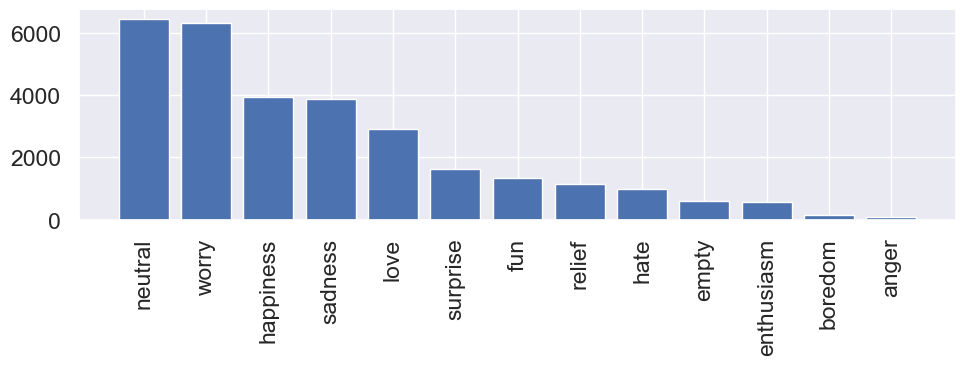

In [3]:
# analizamos el vector objetivo
plt.figure(figsize = (10,4))
plt.bar(
    list(df['sentiment'].value_counts().index), 
    height = df['sentiment'].value_counts())
plt.xticks(rotation = 90)
plt.tight_layout()

**Comentarios**  
La categoría individual más alta es 'neutral', la cual representa 6000 datos aprox. Como se mencionó antes, esta categoría será ignorada en la modelación puesto que escapa de 'positivo' y 'negativo'. Si bien es la categoría singular de mayor frecuencia, al eliminarla aún conservamos aprox el 80% de los datos.

content      False
sentiment    False
dtype: bool

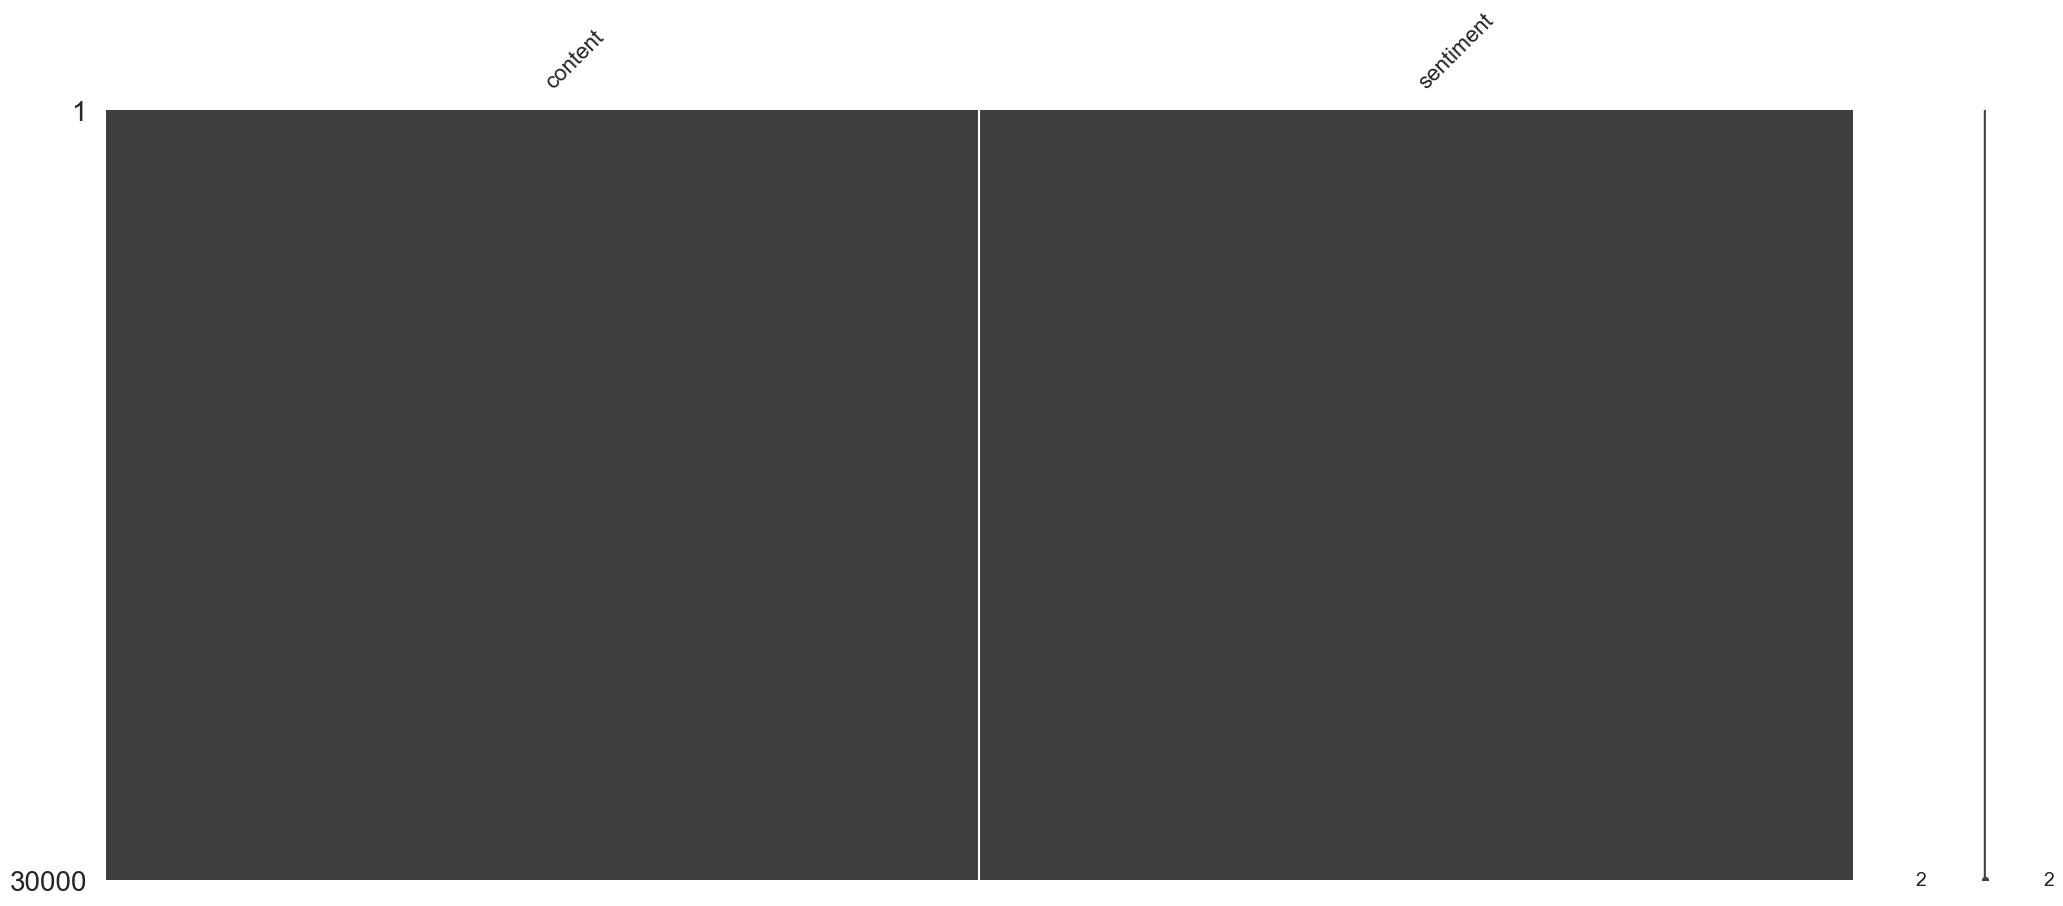

In [4]:
# Patrón de datos perdidos
msngo.matrix(df);
df.isnull().any()

**Comentarios**  
Como se comentó, dentro de los 30 mil tweets no existen valores perdidos. Esto se comprueba tanto gráficamente como con código (df.isnull().any())

## Feature Engineering

En esta sección se muestran las recodificaciones que se realizan sobre el vector objetivo, además de su comportamiento final. 

Luego de esta sección, será necesario retomar el análisis exploratorio. Ya no para revisar el vector objetivo, sino que las variables independientes.

In [5]:
# Recodificar vector objetivo
# Palabras positivas
positive_words = ['happiness','love', 'surprise', 'fun', 'relief', 'enthusiasm']

# Palabras negativas
negative_words = ['worry', 'sadness', 'hate', 'empty', 'boredom', 'anger']

# Cada vez que un sentimiento es positivo lo marcaremos con un 1. Si es negativo será 0. eoc será Nan
df["es_positivo"] = np.where(
    df["sentiment"].isin(positive_words),
    1,
    np.where(
        df["sentiment"].isin(negative_words),
        0,
        pd.NA#np.nan # En este caso estos registros se eliminarían. 
    )
)

df["es_positivo"].value_counts("%", dropna=False) * 100


0       40.073333
1       38.423333
<NA>    21.503333
Name: es_positivo, dtype: float64

**Comentarios**  
Se observa que los tweets neutrales, que ahora son nan, representan un 21.5% del total. Serán eliminados en la siguiente celda.

In [6]:
df_pol = df.dropna()[['content', 'es_positivo']].reset_index(drop = True)
df_pol['es_positivo'] = df_pol['es_positivo'].astype(int)
df_pol['es_positivo'].value_counts()

0    12022
1    11527
Name: es_positivo, dtype: int64

df_pol representa el dataframe con los tweets categorizados en negativos y positivos. Si tiene un 1 en 'es_positivo' significa que representa dicha polaridad. 0 en otro caso. Se observa en este punto que los tweets 'polarizados' presentan clases balanceadas. Esto es una buena noticia de cara a la modelación.

# HITO 2


## Análisis exploratorio (comportamiento variables)
Partiremos analizando cuáles son las palabras que más se repiten tanto en tweets positivos como en tweets negativos. Esto de cara a ver posibles coincidencias e incluirlas en nuestra lista de stop_words

In [7]:
# Definimos el lematizador y stop words mejoradas con las revisiones de las frecuencias
lemmatizer = WordNetLemmatizer()

# Definimos un sw_mejorado con base en las palabras que más se repiten tanto en tweets positivos como negativos
# Lo anterior es fruto de un proceso iterativo.
sw_english = stopwords.words("english")
sw_mejorado = (sw_english + 
               ['day', 'get', 'like', 'today', 'im', 'http','com', 'well', 'far', 'one', 'go', 'back'])


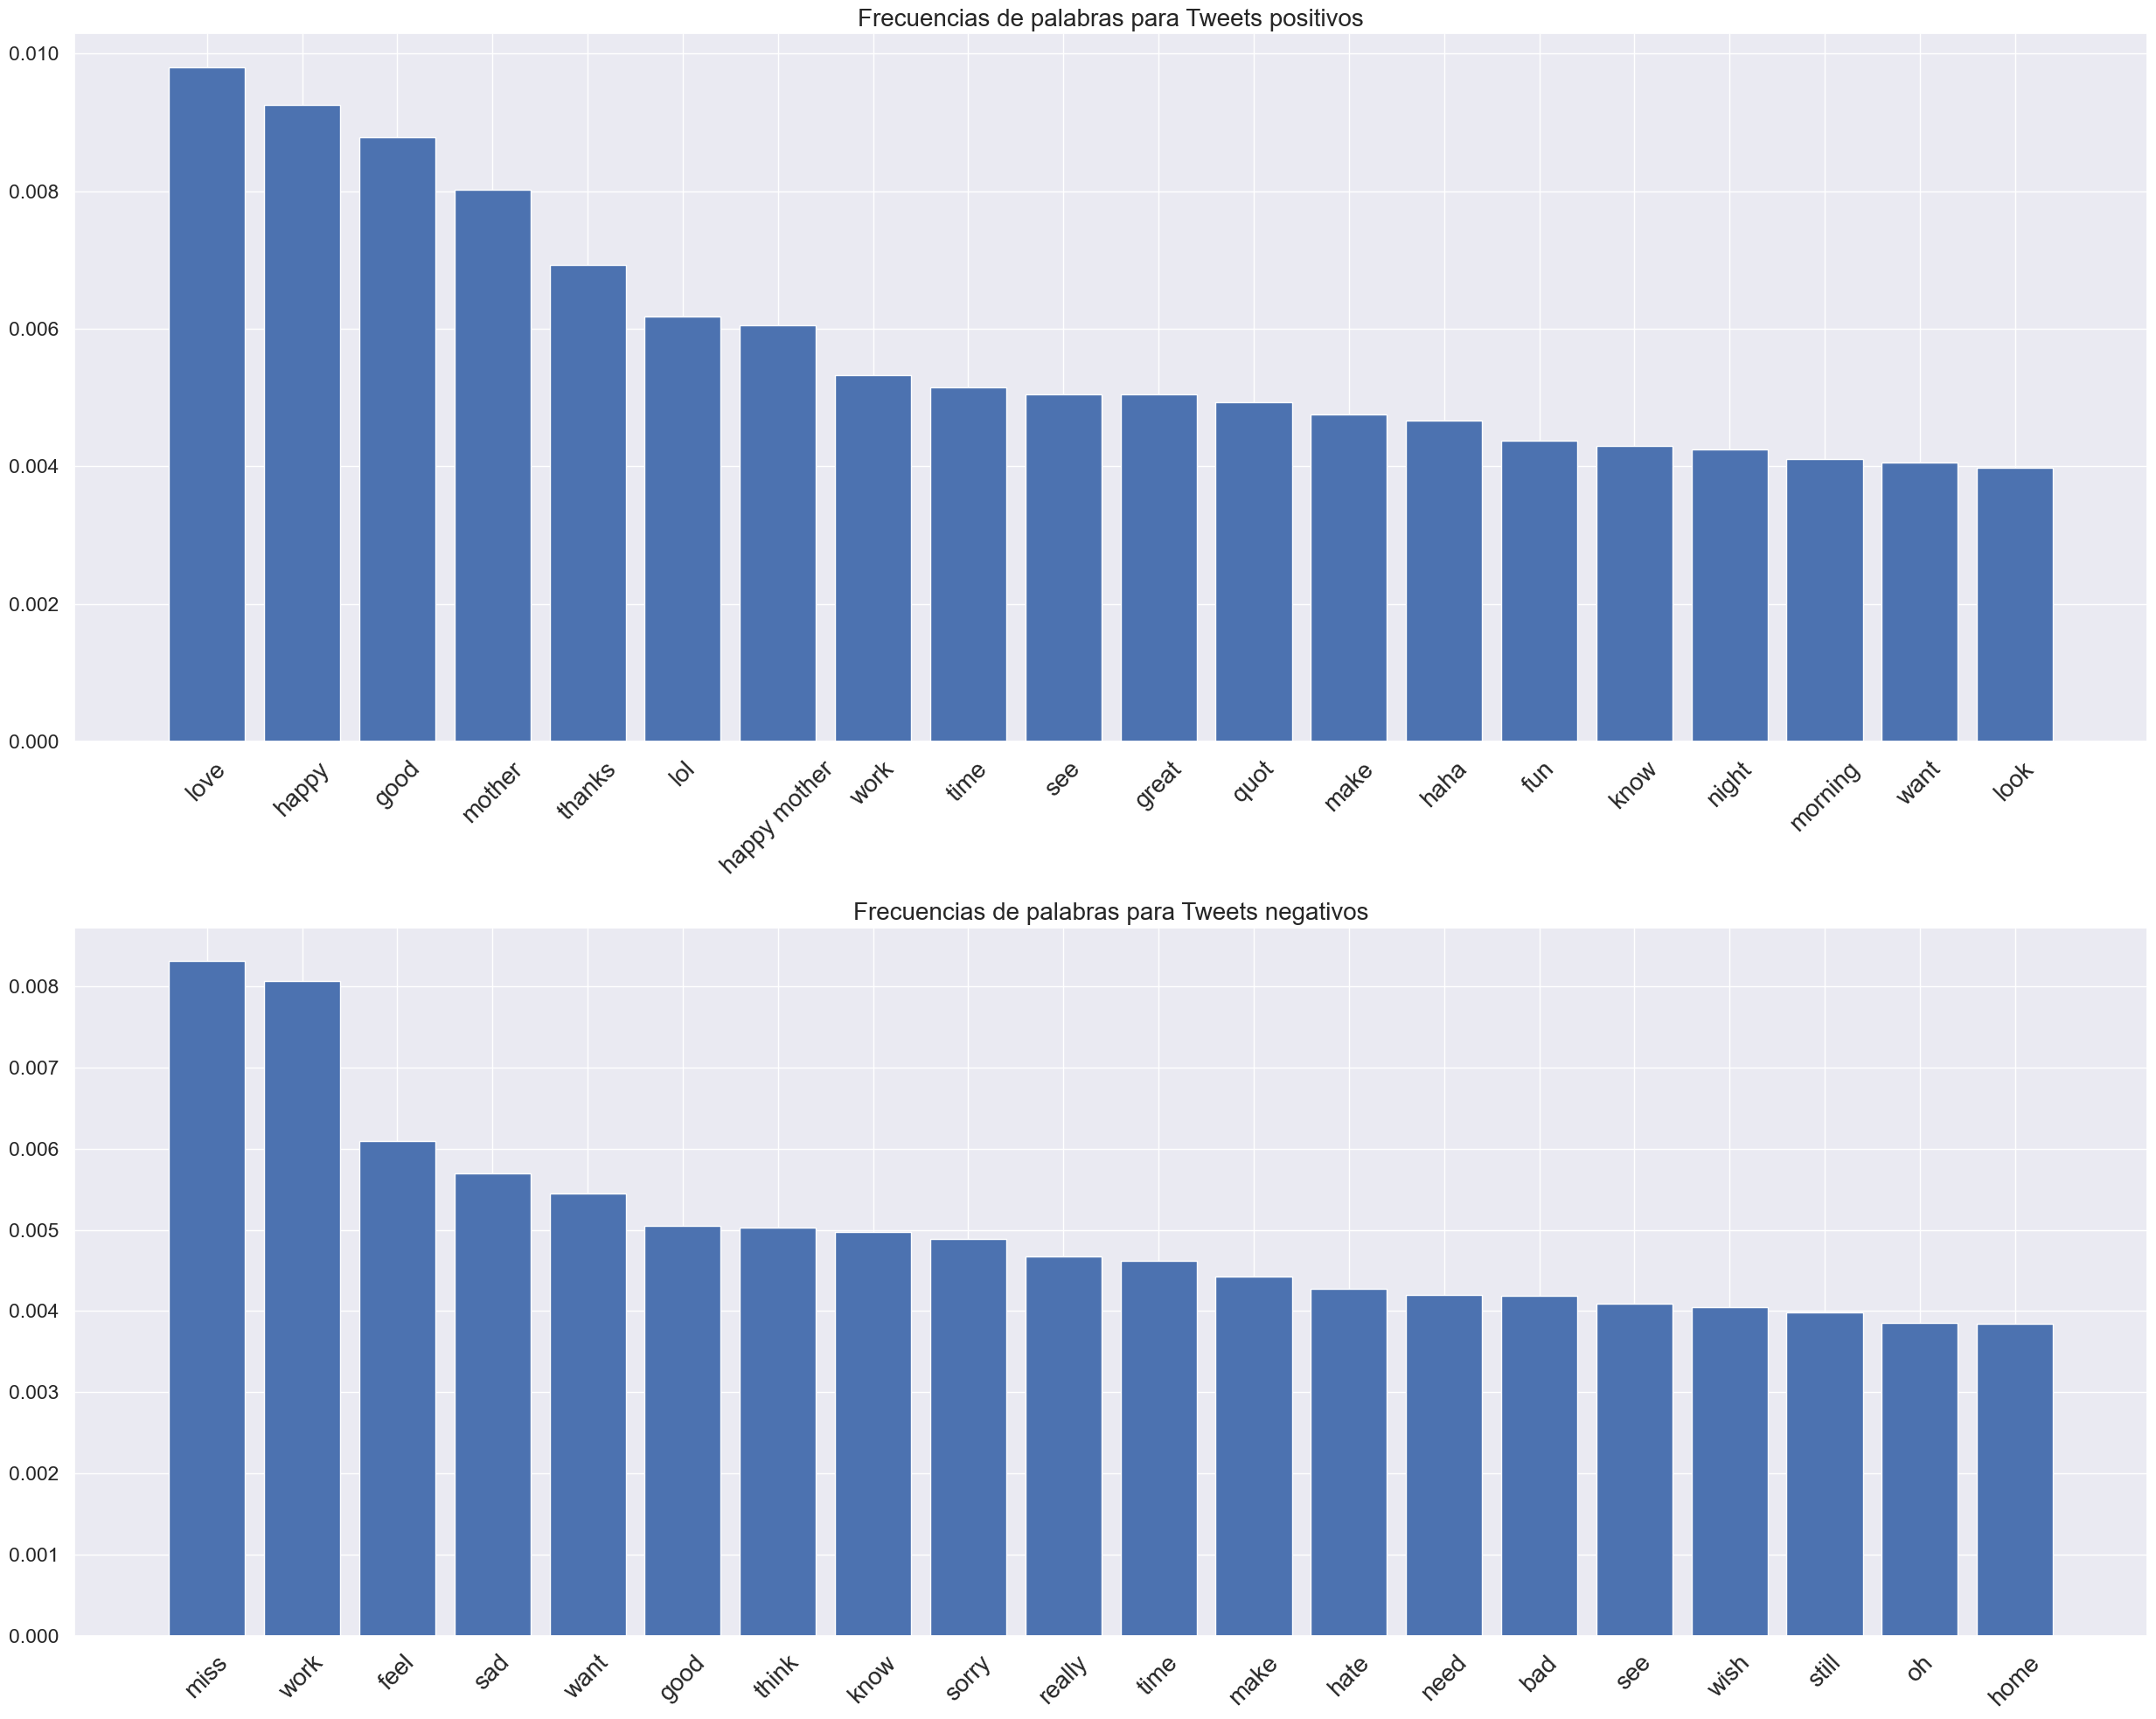

In [8]:
# En esta celda se construye el gráfico. Uno para tweets negativos y otro para positivos.
plt.figure(figsize = (25, 20))

for i, g in enumerate(df_pol['es_positivo'].unique()):
    # get_words_freq_by_polarization retorna un DataFrame con las palabras y la suma de sus frecuencias
    # relativas normalizadas.
    frecuencias = get_words_freq_by_polarization(df_pol, g, sw = sw_mejorado).head(20)
    plt.subplot(2, 1, i + 1)
    plt.bar(frecuencias['Palabra'], frecuencias['Frecuencia'])
    plt.xticks(rotation = 45, fontsize = 20)
    plt.title(f"Frecuencias de palabras para {'Tweets positivos' if g == 1 else 'Tweets negativos' }", size = 20)
    
plt.tight_layout()

**Comentarios**  
Se observa que las palabras que más aparecen en positivo son love, happy, good, mother, thanks. También aparecen expresiones como lol y haha.  
En cambio, para tweets negativos aparecen miss, work, feel, sad, sorry, hate, wish y expresiones como oh.  
A priori, este resultado hace sentido de cara a lo que uno esperaría de un tweet positivo vs uno negativo.

## Declaración grillas
En esta sección, declararemos las 5 grillas de búsqueda para cada uno de nuestros modelos. Como estarán en Pipelines, le agregaremos el nombre del paso en el Pipeline como prefijo al key de diccionario.

Cabe destacar que según los resltados que se han ido obteniendo las grillas han cambiado respecto a lo inicialmente propuesto. Sin embargo, los hiperparámetros a variar son los mismos.

In [9]:
# Declarar las grillas de los 5 modelos
grid_lr = { 
    #'vect__max_features' : [500, 1000, 1500, 5000],
    'lr__C': [0.001, 0.01, 0.1, 1, 10], 
    'lr__penalty': ['l2', 'none']
}

grid_rfc = {
    #'vect__max_features' : [500, 1000, 1500, 5000],
    'rf__min_samples_split': [10, 100],
    'rf__n_estimators': [50, 100, 150],
    'rf__max_depth' : [10, 100, 200, 300]
}

grid_svc = {
    #'vect__max_features' : [500, 1000, 1500, 5000],
    'svc__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 
    'svc__gamma': [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
}

grid_gb = {
    #'vect__max_features' : [500, 1000, 1500, 5000],
    'gb__learning_rate': [0.01, 0.1, 0.5],
    'gb__n_estimators': [50, 100, 500, 1000, 2000],
    'gb__subsample': [0.1, 0.5 ,0.9, 1]
}

# Grilla tentativa, después probaremos con pesos diferentes
grid_vc = {
    #'vect__max_features' : [500, 1000, 1500, 5000],
    'vc__voting': ['hard', 'soft'],
    'vc__weights': [[0.25, 0.25, 0.25, 0.25], [.4, 0.1, 0.4, 0.1]]
}

## Modelación
En la presente sección generaremos los modelos solicitados. Al final, se presentan los comentarios sobre las métricas.

In [10]:
# Debemos partir por un train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_pol['content'],
                                                    df_pol['es_positivo'],
                                                    test_size = 0.33, 
                                                    random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15777,), (7772,), (15777,), (7772,))

**Comentarios**  
Tenemos 15777 tweets para entrenar y 7772 para hacer testing

In [11]:
# Definimos un vectorizador que aplicará en todos los pipelines

# Definimos max_features = 1000. En 500dio peores resultados.

vectorizer = TfidfVectorizer(
        analyzer="word", # Procesar palabras, no "caracteres"
        preprocessor= text_preprocessor, # Ahora text_preprocessor solo tiene un input obligatorio
        sublinear_tf=True, # google dice que sí
        min_df=5, # aumentar a 5 con más datos (cant. mínima de ocurrencias para preservar palabra, evita of)
        norm='l2', # norma euclídea de regularización (evita of, puede empeorar desempeño en train)
        encoding='latin-1', 
        ngram_range=(1, 2), # considerar palabras aisladas y pares de palabras
        stop_words= sw_mejorado,
        max_features = 1500
    )

### Modelo 1: Logistic Regression

In [12]:
# Carga del modelo desde el archivo
lr_model = pickle.load(open('Jorge-Hoffmann-prueba-1-m1-lr.sav', 'rb'))

# Predicción
lr_yhat = lr_model.predict(X_test)
print(classification_report(y_test, lr_yhat))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74      3957
           1       0.74      0.70      0.72      3815

    accuracy                           0.73      7772
   macro avg       0.73      0.73      0.73      7772
weighted avg       0.73      0.73      0.73      7772



**Comentarios**  
Se muestran los resultados para el primer modelo: Logistic Regression. Tiene un F1 de 0.72 para predecir Tweets positivos y de 0.74 para predecir tweets negativos.



### Modelo 2: Random Forest Classifier

In [13]:
# Carga del modelo desde el archivo
rf_model = pickle.load(open('Jorge-Hoffmann-prueba-1-m2-rf.sav', 'rb'))

# Predicción
rf_yhat = rf_model.predict(X_test)
print(classification_report(y_test, rf_yhat))

              precision    recall  f1-score   support

           0       0.70      0.78      0.74      3957
           1       0.74      0.66      0.70      3815

    accuracy                           0.72      7772
   macro avg       0.72      0.72      0.72      7772
weighted avg       0.72      0.72      0.72      7772



**Comentarios**  
vemos que el modelo tiene un comportamiento muy similar a Logistic Regression. Sin embargo, considerando que este modelo tomó mucho más en entrenar, no es tan conveniente.

### Modelo 3: Support vector Classifier.

In [14]:
# Carga del modelo desde el archivo
svc_model = pickle.load(open('Jorge-Hoffmann-prueba-1-m3-svc.sav', 'rb'))

# Predicción
svc_yhat = svc_model.predict(X_test)
print(classification_report(y_test, svc_yhat))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74      3957
           1       0.73      0.69      0.71      3815

    accuracy                           0.73      7772
   macro avg       0.73      0.72      0.72      7772
weighted avg       0.73      0.73      0.73      7772



**Comentarios**  
Resultados en la misma línea que en los dos casos anteriores.

### Modelo 4: Gradient Boosting

In [15]:
# Carga del modelo desde el archivo
gb_model = pickle.load(open('Jorge-Hoffmann-prueba-1-m4-gb.sav', 'rb'))

# Predicción
gb_yhat = gb_model.predict(X_test)
print(classification_report(y_test, gb_yhat))

              precision    recall  f1-score   support

           0       0.70      0.79      0.74      3957
           1       0.75      0.65      0.70      3815

    accuracy                           0.72      7772
   macro avg       0.72      0.72      0.72      7772
weighted avg       0.72      0.72      0.72      7772



### Modelo 5: Voting classifier
En este caso, entrenaremos el voting classifier con los hiperparámetros obtenidos de los grid search anteriores.

In [16]:
# Acá tenemos que extraer únicamente los parámetros que usamos en las grillas para cargarlos en estimators
from operator import itemgetter
print('Hiperparámetros de Logistic Regression')
print(itemgetter('max_iter', 'random_state', 'C', 'penalty')(lr_model[1].get_params()))
print()
print('Hiperparámetros de Random Forest')
print(itemgetter('random_state', 'min_samples_split', 'n_estimators', 'max_depth')(rf_model[1].get_params()))
print()
print('Hiperparámetros de SVC')
print(itemgetter('random_state', 'kernel','C', 'gamma')(svc_model[1].get_params()))
print()
print('Hiperparámetros de Gradient Boosting')
print(itemgetter('learning_rate', 'n_estimators','subsample')(gb_model[1].get_params()))
print()


Hiperparámetros de Logistic Regression
(200, None, 1, 'l2')

Hiperparámetros de Random Forest
(42, 100, 150, 200)

Hiperparámetros de SVC
(42, 'rbf', 1, 1)

Hiperparámetros de Gradient Boosting
(0.1, 1000, 1)



In [17]:
# Carga del modelo desde el archivo
vc_model = pickle.load(open('Jorge-Hoffmann-prueba-1-m5-vc.sav', 'rb'))

# Predicción
vc_yhat = vc_model.predict(X_test)
print(classification_report(y_test, vc_yhat))

              precision    recall  f1-score   support

           0       0.72      0.77      0.75      3957
           1       0.75      0.69      0.72      3815

    accuracy                           0.73      7772
   macro avg       0.73      0.73      0.73      7772
weighted avg       0.73      0.73      0.73      7772



## Presentar métricas de desempeño

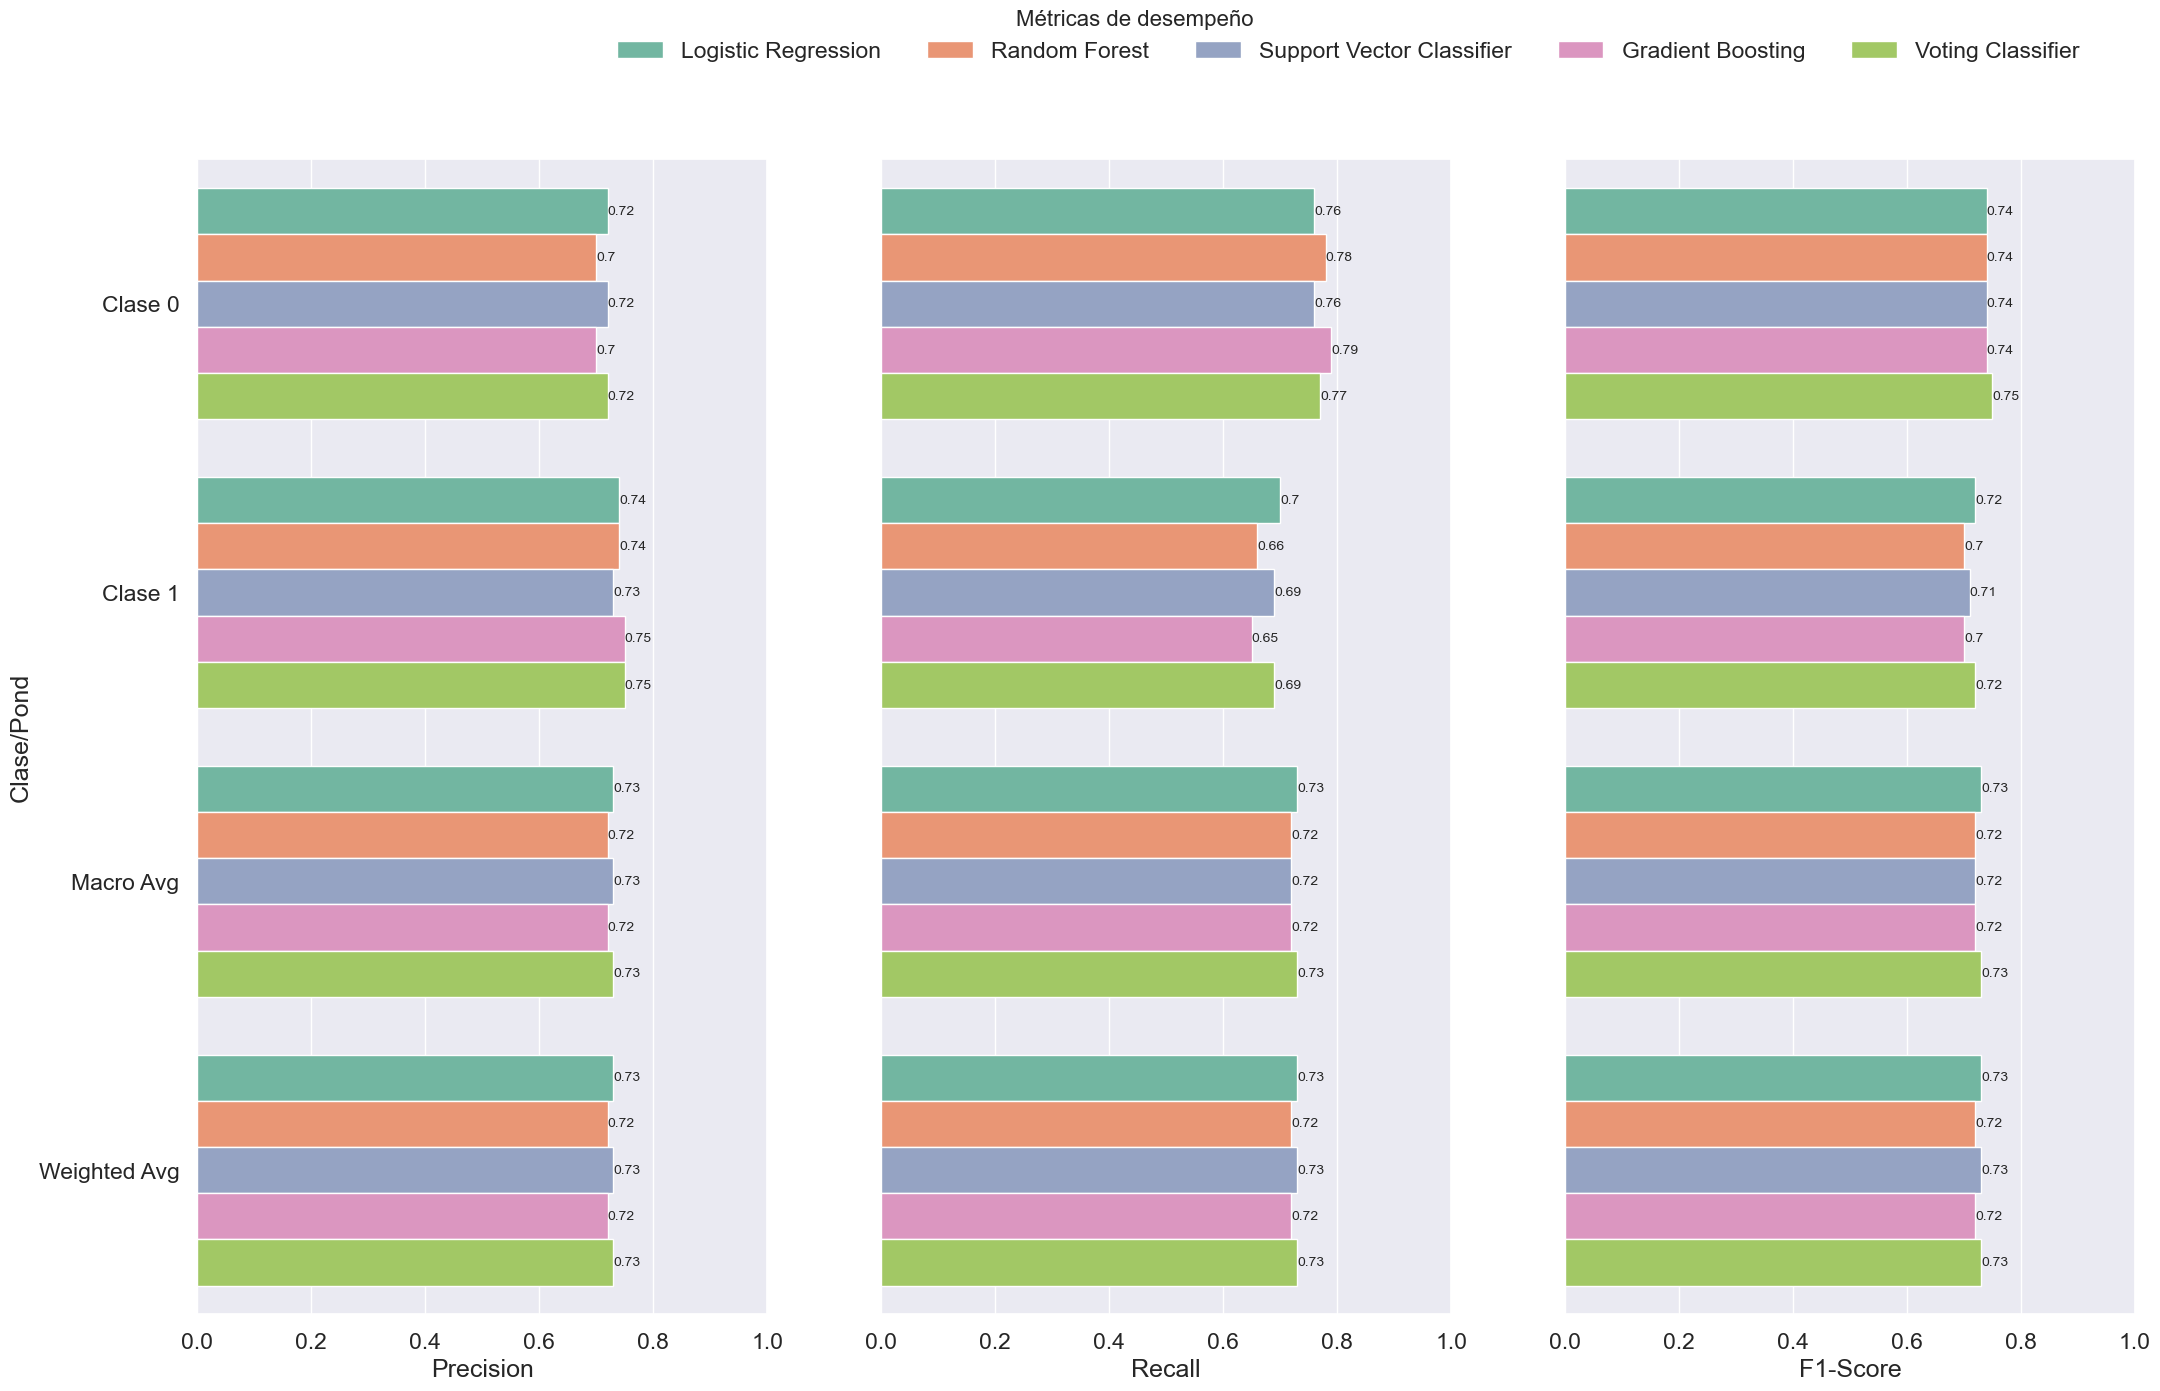

In [18]:
metrics_lr  = classification_report(y_test, lr_yhat, output_dict=True)
metrics_rf  = classification_report(y_test, rf_yhat, output_dict=True)
metrics_svc = classification_report(y_test, svc_yhat, output_dict=True)
metrics_gb  = classification_report(y_test, gb_yhat, output_dict=True)
metrics_vc  = classification_report(y_test, vc_yhat, output_dict=True)

reports = [
    metrics_lr, 
    metrics_rf, 
    metrics_svc,
    metrics_gb, 
    metrics_vc 
]

labels = [
    'Logistic Regression',
    'Random Forest',
    'Support Vector Classifier',
    'Gradient Boosting',
    'Voting Classifier'    
]
df_metrics = plot_metrics(reports, labels, figsize = (25, 15))


**Comentarios**

Dado que estamos en un problema con clases balanceadas (según lo revisado en el análisis exploratorio) podemos fijarnos en el weighted avg.

Allí, vemos que los modelos tienen un rendimiento bastante parejo. Sin embargo, destacan Logistic Regression, Support Vector Classifier y Voting Classifier. Luego, si miramos el rendimiento en la clase 0 y clase 1, nuevamente se ven pocas diferencias. Sin embargo, el VC siempre está top 1. Así, se decide picklear el voting classifier. En segundo lugar picklearemos el logistic regression ya que tiene muy buen rendimiento y es un modelo más sencillo.

## Serialización mejores modelos

In [19]:
pickle.dump(vc_model, open('Jorge-Hoffmann-prueba-1-mejor_modelo_1-vc.sav','wb'))
pickle.dump(lr_model, open('Jorge-Hoffmann-prueba-1-mejor_modelo_2-lr.sav','wb'))